In [9]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import shap
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim




In [3]:
school_df = pd.read_csv('/content/drive/MyDrive/3signet-Projects/week 3 Task/new_data.csv', index_col=0)
X = school_df.drop('Target', axis=1)
y = school_df['Target']
X.columns

Index(['AdmGrades_category', 'Admission grade', 'Age at enrollment',
       'Application mode_39', 'Completion_Age_Interaction',
       'Completion_Grade_Interaction', 'Completion_Rate_1st',
       'Completion_Rate_2nd', 'Course_8014', 'Course_9991',
       'Curricular units (Average grade)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (grade)', 'Father's occupation_0',
       'Father's occupation_90', 'Father's occupation_others',
       'Father's qualification_3', 'Father's qualification_34',
       'Father's qualification_37', 'Grade_Interaction',
       'Grouped Admission grade', 'Grouped Age at enrollment',
       'Grouped Curricular units 1st sem (grade)',
       'Grouped Curricular units 2nd sem (grade)',
       'Grouped Previous qualification (grade)', 'Internati

In [ ]:
X.shape

(3452, 74)

In [4]:
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
y_test.value_counts()

,count
Target,
0,423
1,268


## GridSearchCv

In [ ]:
def gridsearch(model, params,):
    gridsearch = GridSearchCV(estimator=model,param_grid=params,cv=10,n_jobs=1)
    gridsearch.fit(X_train,y_train)
    train_pred = gridsearch.predict(X_train)
    test_pred = gridsearch.predict(X_test)
    model_pred_proba=gridsearch.predict_proba(X_test)[:,1]
    print('training accuracy: ',accuracy_score(train_pred,y_train))
    print('testing accuracy: ',accuracy_score(test_pred,y_test))
    scores = cross_val_score(gridsearch, X_train, y_train, cv=10)  # 10-fold cross-validation
    print("Mean cross-validation score:", np.mean(scores))
    print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification report:\n", classification_report(y_test, test_pred))
    print("Best parameters:", gridsearch.best_params_)



## RandomizedSearchCV

In [ ]:
def randomizedsearch(model, params,):
    randomsearch = RandomizedSearchCV(model,params, n_iter=100,
    scoring='accuracy',
    cv=10,
    random_state=42,
    n_jobs=-1)
    randomsearch.fit(X_train,y_train)
    train_pred = randomsearch.predict(X_train)
    test_pred = randomsearch.predict(X_test)
    model_pred_proba=randomsearch.predict_proba(X_test)[:,1]
    print('training accuracy: ',accuracy_score(train_pred,y_train))
    print('testing accuracy: ',accuracy_score(test_pred,y_test))
    scores = cross_val_score(randomsearch, X_train, y_train, cv=10)  # 10-fold cross-validation
    print("Mean cross-validation score:", np.mean(scores))
    print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification report:\n", classification_report(y_test, test_pred))
    print("Best parameters:", randomsearch.best_params_)

In [5]:
def plot_learning_curve(model):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1,50), verbose=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training scores")
    plt.plot(train_sizes, test_mean, label="Testing scores")

    plt.title(f'{model} Learning curve')
    plt.xlabel('Training size')
    plt.ylabel('Accuracy score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [6]:
def tuned(model,plot_learning_curve=plot_learning_curve):
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    model_pred_proba=model.predict_proba(X_test)[:,1]
    print('training accuracy: ',accuracy_score(train_pred,y_train))
    print('testing accuracy: ',accuracy_score(test_pred,y_test))
    scores = cross_val_score(model, X_train, y_train, cv=10)  # 10-fold cross-validation
    print("Mean cross-validation score:", np.mean(scores))
    print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
    print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
    print("Classification report:\n", classification_report(y_test, test_pred))
    plot_learning_curve(model)

## Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
params_logreg ={
    'penalty':['l1', 'l2', None],
    'max_iter': [100,200,300,400,500,600,700,800,900,1000],
    'multi_class':['auto', 'ovr', 'multinomial'],
    'C':np.arange(0.001,0.01,0.1),
    'solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

randomizedsearch(logreg, params_logreg)

training accuracy:  0.9185077870336834
testing accuracy:  0.9261939218523878


KeyboardInterrupt: 

In [ ]:
gridsearch(logreg, params_logreg)
plot_learning_curve(logreg)

In [ ]:
space= {
'penalty':hp.choice('penalty',['l2', None]),
    'max_iter': hp.choice('max_iter',[100,200,300,400,500,600,700,800,900,1000]),
    'multi_class': hp.choice('multi_class',['auto', 'ovr', 'multinomial']),
    'C':hp.choice('C',[0.001,0.01,0.1]),
    'solver':hp.choice('solver',['lbfgs','newton-cg',  'sag', 'saga']),
    'class_weight':hp.choice('class_weight',['balanced', None]),
}



def objective(space):
  model = LogisticRegression(
      penalty=space['penalty'],
      max_iter=space['max_iter'],
      multi_class=space['multi_class'],
      C=space['C'],
      solver=space['solver'],
      class_weight=space['class_weight'])
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  model_pred_proba=model.predict_proba(X_test)[:,1]
  print('training accuracy: ',accuracy_score(train_pred,y_train))
  print('testing accuracy: ',accuracy_score(test_pred,y_test))
  scores = cross_val_score(model, X_train, y_train, cv=10) # 10-fold cross-validation
  print("Mean cross-validation score:", np.mean(scores))
  print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
  print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
  print("Classification report:\n", classification_report(y_test, test_pred))
  return {'loss':-np.mean(scores), 'status': STATUS_OK}



trials =Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,max_evals=80, trials=trials)
best

training accuracy: 
0.9148859109018471
testing accuracy: 
0.9204052098408104
Mean cross-validation score:
0.9112672003348508
roc_auc: 
0.9569792879573762
Confusion matrix:

[[402  21]
 [ 34 234]]
Classification report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       423
           1       0.92      0.87      0.89       268

    accuracy                           0.92       691
   macro avg       0.92      0.91      0.92       691
weighted avg       0.92      0.92      0.92       691

training accuracy: 
0.9145237232886635
testing accuracy: 
0.9232995658465991
Mean cross-validation score:
0.9141644430492335
roc_auc: 
0.9580113616315584
Confusion matrix:

[[403  20]
 [ 33 235]]
Classification report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       423
           1       0.92      0.88      0.90       268

    accuracy                           0.92       691
   macro avg   

KeyboardInterrupt: 

training accuracy:  0.9329952915610286
testing accuracy:  0.9247467438494935
Mean cross-validation score: 0.9243067545649557
roc_auc:  0.9658004304717548
Confusion matrix:
 [[406  17]
 [ 35 233]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       423
           1       0.93      0.87      0.90       268

    accuracy                           0.92       691
   macro avg       0.93      0.91      0.92       691
weighted avg       0.93      0.92      0.92       691

[learning_curve] Training set sizes: [  24   75  125  175  225  275  325  376  426  476  526  576  627  677
  727  777  827  878  928  978 1028 1078 1128 1179 1229 1279 1329 1379
 1430 1480 1530 1580 1630 1681 1731 1781 1831 1881 1931 1982 2032 2082
 2132 2182 2233 2283 2333 2383 2433 2484]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.0min finished


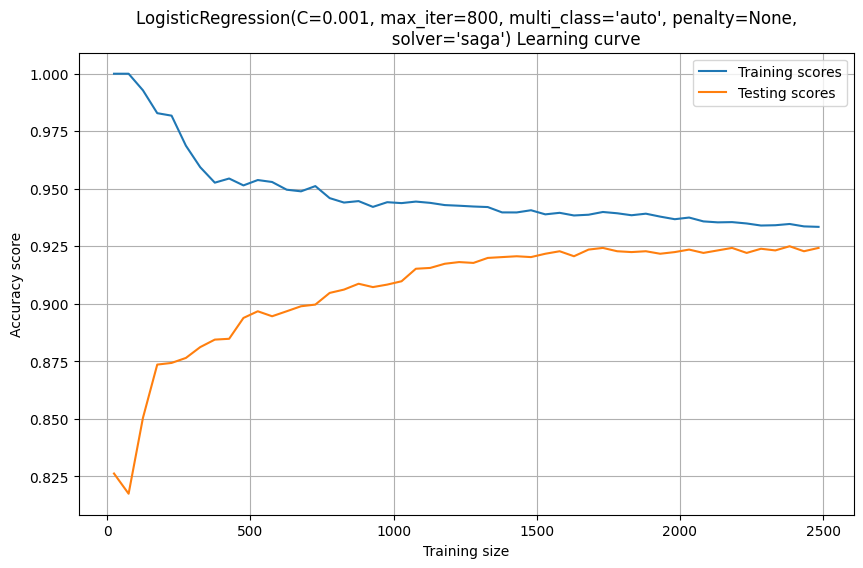

In [7]:
logreg = LogisticRegression(C=0.001, class_weight=None,max_iter=800, multi_class='auto', penalty=None, solver='saga')
tuned(logreg)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

#### Decision Tree

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
# Checking for the best parameters
params_dt ={
    'criterion':['gini', 'entropy'],
    'splitter': ['best','random'],
    'max_features':['auto','sqrt', 'log2'],
    'max_depth':[2,5,6,7,10],
    'min_samples_split':[1,2,3,4,5,6,7],
    'min_samples_leaf':[1,2,3,4,5,6,7]
}

randomizedsearch(dt, params_dt)

In [ ]:
gridsearch(dt, params_dt)
plot_learning_curve(dt)

In [ ]:

space = {
    'criterion':hp.choice('criterion',['gini', 'entropy']),
    'splitter': hp.choice('splitter',['best','random']),
    'max_features': hp.choice('max_features',['sqrt', 'log2']),
    'max_depth':hp.quniform('max_depth',1,10,1),
    'min_samples_split':hp.quniform('min_samples_split',2,10,1),
    'min_samples_leaf':hp.quniform('min_samples_leaf',2,10,1)
}

def objective(space):
  model = DecisionTreeClassifier(
      criterion=space['criterion'],
      splitter=space['splitter'],
      max_features=space['max_features'],
      max_depth=int(space['max_depth']),
      min_samples_split=int(space['min_samples_split']),
      min_samples_leaf=int(space['min_samples_leaf']))
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  model_pred_proba=model.predict_proba(X_test)[:,1]
  print('training accuracy: ',accuracy_score(train_pred,y_train))
  print('testing accuracy: ',accuracy_score(test_pred,y_test))
  scores = cross_val_score(model, X_train, y_train, cv=10) # 10-fold cross-validation
  print("Mean cross-validation score:", np.mean(scores))
  print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
  print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
  print("Classification report:\n", classification_report(y_test, test_pred))
  return {'loss':-np.mean(scores), 'status': STATUS_OK}



trials =Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,max_evals=80, trials=trials)
best

training accuracy: 
0.9011227816008692
testing accuracy: 
0.9117221418234442
Mean cross-validation score:
0.8601907078951501
roc_auc: 
0.9296557990190889
Confusion matrix:

[[403  20]
 [ 41 227]]
Classification report:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       423
           1       0.92      0.85      0.88       268

    accuracy                           0.91       691
   macro avg       0.91      0.90      0.91       691
weighted avg       0.91      0.91      0.91       691

training accuracy: 
0.8913437160449112
testing accuracy: 
0.8929088277858177
Mean cross-validation score:
0.8489457437346308
roc_auc: 
0.9063415193535866
Confusion matrix:

[[392  31]
 [ 43 225]]
Classification report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       423
           1       0.88      0.84      0.86       268

    accuracy                           0.89       691
   macro avg   

{'criterion': 1,
 'max_depth': 7.0,
 'max_features': 0,
 'min_samples_leaf': 8.0,
 'min_samples_split': 8.0,
 'splitter': 0}

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_leaf=8, min_samples_split=8, splitter='best')
tuned(dt)


training accuracy:  0.9123505976095617
testing accuracy:  0.8972503617945007
Mean cross-validation score: 0.8895359179615967
roc_auc:  0.9240234995236583
Confusion matrix:
 [[405  18]
 [ 53 215]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       423
           1       0.92      0.80      0.86       268

    accuracy                           0.90       691
   macro avg       0.90      0.88      0.89       691
weighted avg       0.90      0.90      0.90       691

[learning_curve] Training set sizes: [  24   75  125  175  225  275  325  376  426  476  526  576  627  677
  727  777  827  878  928  978 1028 1078 1128 1179 1229 1279 1329 1379
 1430 1480 1530 1580 1630 1681 1731 1781 1831 1881 1931 1982 2032 2082
 2132 2182 2233 2283 2333 2383 2433 2484]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

## Support Machine Vector

In [ ]:
svm = SVC(probability=True,C=1,gamma=0.1)

In [ ]:
# Performing cross-validation
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)  # 10-fold cross-validation

# Printing the scores
print("Cross-validation scores:", svm_scores)
print("Mean cross-validation score:", np.mean(svm_scores))
svm.fit(X_train,y_train)
svm_train_pred = svm.predict(X_train)
svm_test_pred = svm.predict(X_test)
print('training accuracy: ',accuracy_score(svm_train_pred,y_train))
print('testing accuracy: ',accuracy_score(svm_test_pred,y_test))
print("Confusion matrix:\n", confusion_matrix(y_test, svm_test_pred))
print("Classification report:\n", classification_report(y_test, svm_test_pred))

In [ ]:

# Checking for the best parameters
params_svm ={
    'gamma':[0.0001,0.001,0.01,0.1, 1, 10, 100],
   'C':[0.01,0.05,0.01,0.5,1,10,15,20],

}

randomizedsearch(svm, params_svm)


In [ ]:
gridsearch(svm, params_svm)
plot_learning_curve(svm)

In [ ]:
space= {
'gamma':hp.choice('gamma',[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]),
'C':hp.choice('C',[0.01,0.05,0.01,0.5,1,10,15,20])
}


def objective(space):
  model = SVC(probability=True,
      gamma=space['gamma'],
      C=space['C'])
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  model_pred_proba=model.predict_proba(X_test)[:,1]
  print('training accuracy: ',accuracy_score(train_pred,y_train))
  print('testing accuracy: ',accuracy_score(test_pred,y_test))
  scores = cross_val_score(model, X_train, y_train, cv=10) # 10-fold cross-validation
  print("Mean cross-validation score:", np.mean(scores))
  print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
  print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
  print("Classification report:\n", classification_report(y_test, test_pred))
  return {'loss':-np.mean(scores), 'status': STATUS_OK}



trials =Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,max_evals=80, trials=trials)
best

training accuracy: 
0.6421586381745744
testing accuracy: 
0.6410998552821997
Mean cross-validation score:
0.6120977868466488
roc_auc: 
0.9197805299742422
Confusion matrix:

[[423   0]
 [248  20]]
Classification report:

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       423
           1       1.00      0.07      0.14       268

    accuracy                           0.64       691
   macro avg       0.82      0.54      0.46       691
weighted avg       0.77      0.64      0.53       691

training accuracy: 
1.0
testing accuracy: 
0.6121562952243126
Mean cross-validation score:
0.6120977868466488
roc_auc: 
0.5
Confusion matrix:

[[423   0]
 [268   0]]
Classification report:

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       423
           1       0.00      0.00      0.00       268

    accuracy                           0.61       691
   macro avg       0.31      0.50      0.38  

{'C': 7, 'gamma': 3}

In [ ]:
svm= SVC(probability=True, C = 20, gamma = 0.001)
tuned(svm)

training accuracy:  0.9308221658819268
testing accuracy:  0.9290882778581766
Mean cross-validation score: 0.923937895673102
roc_auc:  0.962077908330687
Confusion matrix:
 [[416   7]
 [ 42 226]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       423
           1       0.97      0.84      0.90       268

    accuracy                           0.93       691
   macro avg       0.94      0.91      0.92       691
weighted avg       0.93      0.93      0.93       691

[learning_curve] Training set sizes: [  24   75  125  175  225  275  325  376  426  476  526  576  627  677
  727  777  827  878  928  978 1028 1078 1128 1179 1229 1279 1329 1379
 1430 1480 1530 1580 1630 1681 1731 1781 1831 1881 1931 1982 2032 2082
 2132 2182 2233 2283 2333 2383 2433 2484]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
# Checking for the best parameters
params_rf ={
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}
randomizedsearch(rf, params_rf)

In [ ]:
gridsearch(rf, params_rf)
plot_learning_curve(rf)

In [ ]:
space= {
'n_estimators':hp.quniform('n_estimators',100,1000,100),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]),
    'min_samples_leaf': hp.choice('min_samples_leaf',[1, 2, 4]),
    'min_samples_split':hp.choice('min_samples_split',[2, 5, 10]),
    'max_features':hp.choice('max_features',[ 'sqrt', 'log2'])
}



def objective(space):
  model = RandomForestClassifier(
      n_estimators=int(space['n_estimators']),
      max_depth=space['max_depth'],
      min_samples_leaf=space['min_samples_leaf'],
      min_samples_split=space['min_samples_split'],
      max_features=space['max_features'])
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  model_pred_proba=model.predict_proba(X_test)[:,1]
  print('training accuracy: ',accuracy_score(train_pred,y_train))
  print('testing accuracy: ',accuracy_score(test_pred,y_test))
  scores = cross_val_score(model, X_train, y_train, cv=10) # 10-fold cross-validation
  print("Mean cross-validation score:", np.mean(scores))
  print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
  print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
  print("Classification report:\n", classification_report(y_test, test_pred))
  return {'loss':-np.mean(scores), 'status': STATUS_OK}



trials =Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,max_evals=80, trials=trials)
best

training accuracy: 
0.9503802969938429
testing accuracy: 
0.9175108538350217
Mean cross-validation score:
0.9174253126144508
roc_auc: 
0.9561236371334815
Confusion matrix:

[[410  13]
 [ 44 224]]
Classification report:

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       423
           1       0.95      0.84      0.89       268

    accuracy                           0.92       691
   macro avg       0.92      0.90      0.91       691
weighted avg       0.92      0.92      0.92       691

training accuracy: 
0.9547265483520464
testing accuracy: 
0.9160636758321273
Mean cross-validation score:
0.9167019829435462
roc_auc: 
0.9548269291838678
Confusion matrix:

[[409  14]
 [ 44 224]]
Classification report:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       423
           1       0.94      0.84      0.89       268

    accuracy                           0.92       691
   macro avg   

{'max_depth': 0,
 'max_features': 0,
 'min_samples_leaf': 0,
 'min_samples_split': 0,
 'n_estimators': 600.0}

In [10]:
rf = RandomForestClassifier(max_depth = None,max_features = 'sqrt',min_samples_leaf = 1,min_samples_split = 2,n_estimators = 600, random_state=42)
tuned(rf)

training accuracy:  1.0
testing accuracy:  0.9218523878437048


KeyboardInterrupt: 

In [18]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
# shap.force_plot(explainer.expected_value, shap_values, X_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
shap.initjs()

shap.plots.force(explainer.expected_value[0], shap_values[..., 0])
shap.force_plot(explainer.expected_value, shap_values, X_train)

Output hidden; open in https://colab.research.google.com to view.

## Gradient Boosting Classifier

In [ ]:
gbt = GradientBoostingClassifier()
# Checking for the best parameters
params_gbt ={
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.7, 1.0],
    'max_features': ['auto', 'sqrt', 'log2'],
}
randomizedsearch(gbt, params_gbt)

In [ ]:
gridsearch(gbt, params_gbt)
plot_learning_curve(gbt)

In [ ]:
space= {
'n_estimators':hp.quniform('n_estimators',100, 1000,100),
    'learning_rate': hp.choice('learning_rate',[0.01, 0.1, 0.2]),
    'max_depth': hp.choice('max_depth',[3, 5, 7]),
    'min_samples_split':hp.quniform('min_samples_split',2, 10,1),
    'min_samples_leaf':hp.quniform('min_samples_leaf', 2, 10,1),
    'subsample':hp.choice('subsample',[0.5, 0.7, 1.0]),
    'max_features':hp.choice('max_features',[ 'sqrt', 'log2'])
}

def objective(space):
  model = GradientBoostingClassifier(
      n_estimators=int(space['n_estimators']),
      max_depth=space['max_depth'],
      min_samples_leaf=int(space['min_samples_leaf']),
      min_samples_split=int(space['min_samples_split']),
      max_features=space['max_features'],
      subsample=space['subsample'],
      learning_rate=space['learning_rate']
      )
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  model_pred_proba=model.predict_proba(X_test)[:,1]
  print('training accuracy: ',accuracy_score(train_pred,y_train))
  print('testing accuracy: ',accuracy_score(test_pred,y_test))
  scores = cross_val_score(model, X_train, y_train, cv=10) # 10-fold cross-validation
  print("Mean cross-validation score:", np.mean(scores))
  print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
  print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
  print("Classification report:\n", classification_report(y_test, test_pred))
  return {'loss':-np.mean(scores), 'status': STATUS_OK}



trials =Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,max_evals=80, trials=trials)
best

training accuracy: 
0.9536399855124955
testing accuracy: 
0.9319826338639653
Mean cross-validation score:
0.9203225553288338
roc_auc: 
0.9610458346565047
Confusion matrix:

[[414   9]
 [ 38 230]]
Classification report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       423
           1       0.96      0.86      0.91       268

    accuracy                           0.93       691
   macro avg       0.94      0.92      0.93       691
weighted avg       0.93      0.93      0.93       691

training accuracy: 
0.9793553060485332
testing accuracy: 
0.9290882778581766
Mean cross-validation score:
0.914528069900068
roc_auc: 
0.9587964433153382
Confusion matrix:

[[407  16]
 [ 33 235]]
Classification report:

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       423
           1       0.94      0.88      0.91       268

    accuracy                           0.93       691
   macro avg    

{'learning_rate': 1,
 'max_depth': 1,
 'max_features': 1,
 'min_samples_leaf': 5.0,
 'min_samples_split': 6.0,
 'n_estimators': 500.0,
 'subsample': 2}

In [ ]:
gbt =GradientBoostingClassifier(n_estimators=500,min_samples_split=6,min_samples_leaf= 5,learning_rate = 0.1,max_depth = 5,max_features= 'log2',subsample = 1,random_state=42)
tuned(gbt)

training accuracy:  1.0
testing accuracy:  0.9247467438494935


KeyboardInterrupt: 

# XGBClassifier

In [ ]:
xgb = XGBClassifier()
# Checking for the best parameters
params_xgb ={
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
}
randomizedsearch(xgb, params_xgb)

In [ ]:
gridsearch(xgb, params_xgb)
plot_learning_curve(xgb)

In [ ]:
space= {
'n_estimators':hp.choice('n_estimators',[100, 200, 300]),
    'learning_rate': hp.choice('learning_rate',[0.01, 0.1, 0.2]),
    'max_depth': hp.choice('max_depth',[3, 5, 7, 9]),
    'min_child_weight':hp.quniform('min_child_weight',1,10,1),
    'subsample':hp.choice('subsample',[0.5, 0.6, 0.7, 0.8, 1.0]),
    'colsample_bytree':hp.choice('colsample_bytree',[0.5, 0.6, 0.7, 0.8, 1.0]),
    'gamma':hp.choice('gamma',[0, 0.1, 0.2, 0.3])
}



def objective(space):
  model = XGBClassifier(
      n_estimators=space['n_estimators'],
      learning_rate=space['learning_rate'],
      max_depth=space['max_depth'],
      min_child_weight=space['min_child_weight'],
      subsample=space['subsample'],
      colsample_bytree=space['colsample_bytree'],
      gamma=space['gamma'])
  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  model_pred_proba=model.predict_proba(X_test)[:,1]
  print('training accuracy: ',accuracy_score(train_pred,y_train))
  print('testing accuracy: ',accuracy_score(test_pred,y_test))
  scores = cross_val_score(model, X_train, y_train, cv=10) # 10-fold cross-validation
  print("Mean cross-validation score:", np.mean(scores))
  print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
  print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
  print("Classification report:\n", classification_report(y_test, test_pred))
  return {'loss':-np.mean(scores), 'status': STATUS_OK}



trials =Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,max_evals=80, trials=trials)
best

training accuracy: 
0.9952915610286128
testing accuracy: 
0.9261939218523878
Mean cross-validation score:
0.9127086276356406
roc_auc: 
0.9551974171694718
Confusion matrix:

[[408  15]
 [ 36 232]]
Classification report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       423
           1       0.94      0.87      0.90       268

    accuracy                           0.93       691
   macro avg       0.93      0.92      0.92       691
weighted avg       0.93      0.93      0.93       691

training accuracy: 
0.9366171676928648
testing accuracy: 
0.9276410998552822
Mean cross-validation score:
0.9127099356458954
roc_auc: 
0.9570763205250344
Confusion matrix:

[[411  12]
 [ 38 230]]
Classification report:

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       423
           1       0.95      0.86      0.90       268

    accuracy                           0.93       691
   macro avg   

{'colsample_bytree': 1,
 'gamma': 3,
 'learning_rate': 1,
 'max_depth': 2,
 'min_child_weight': 3.0,
 'n_estimators': 0,
 'subsample': 2}

In [24]:
xgb= XGBClassifier(colsample_bytree=0.7,gamma=0.3,learning_rate=0.01,max_depth=5,min_child_weight=3.0,n_estimators=200,subsample=0.5)
tuned(xgb)

training accuracy:  0.9300977906555595
testing accuracy:  0.9232995658465991
Mean cross-validation score: 0.9163396641029665
roc_auc:  0.9602431106876963
Confusion matrix:
 [[414   9]
 [ 44 224]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       423
           1       0.96      0.84      0.89       268

    accuracy                           0.92       691
   macro avg       0.93      0.91      0.92       691
weighted avg       0.93      0.92      0.92       691

[learning_curve] Training set sizes: [  24   75  125  175  225  275  325  376  426  476  526  576  627  677
  727  777  827  878  928  978 1028 1078 1128 1179 1229 1279 1329 1379
 1430 1480 1530 1580 1630 1681 1731 1781 1831 1881 1931 1982 2032 2082
 2132 2182 2233 2283 2333 2383 2433 2484]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

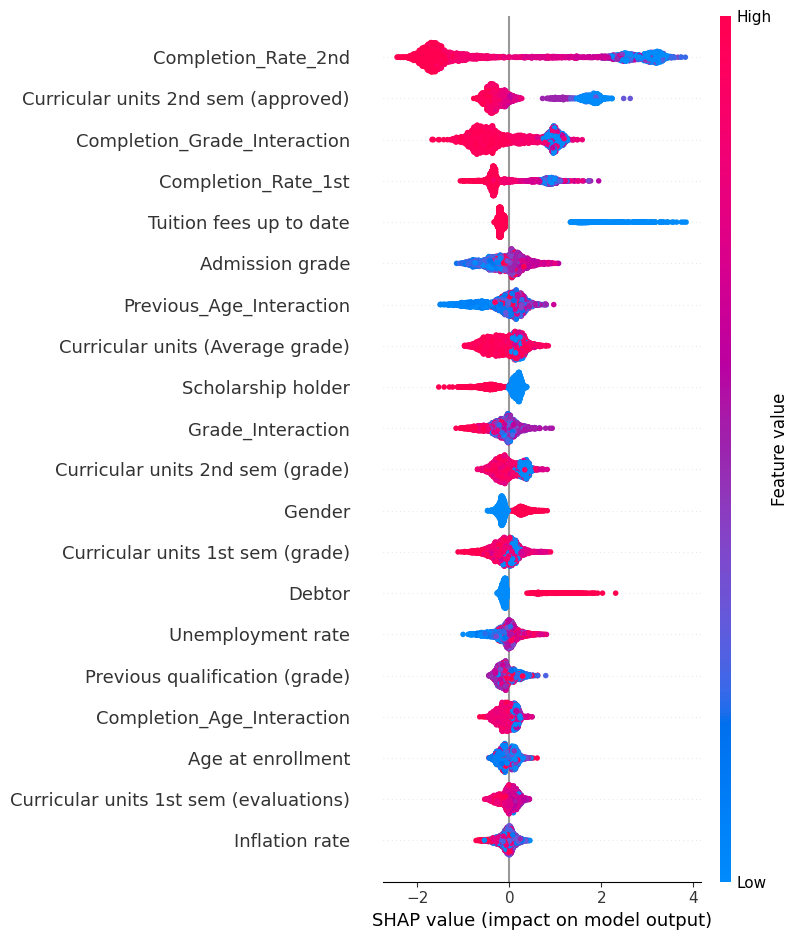

In [26]:
# Create a SHAP explainer and calculate SHAP values
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

# Create a summary plot
shap.summary_plot(shap_values, X_train)

# Deep Learning with Pytorch

In [ ]:
# Create a model class that inherits the nn.Module

class Model(nn.Module):
    def __init__(self, in_features=74, h1=50, h2=30, h3=20, h4=10, output_features=2):
        super().__init__()   # Instantiate our nn.Module
        self.fc1=nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,h4)
        self.out= nn.Linear(h4,output_features)

    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.relu(self.fc4(x))
        x= self.out(x)

        return x

In [ ]:
# Pick a random seed for randomization
torch.manual_seed(41)

# Create an instance of model
model = Model()

In [ ]:
# Convert X features to float tensors
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)

# Convert y labels to tensors long(int)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

#  Setthe criterion of model to measure the error
criterion = CrossEntropyLoss()

# Set the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Get unique values and their counts
unique_values, counts = torch.unique(y_test, return_counts=True)

# Display results
for value, count in zip(unique_values, counts):
    print(f'Value: {value.item()}, Count: {count.item()}')

Value: 0, Count: 423
Value: 1, Count: 268


In [ ]:
# Train our model
epochs = 50
losses = []

for i in range(epochs):
  y_pred = model.forward(X_train)
  loss = criterion(y_pred, y_train)
  losses.append(loss.detach().numpy())

  if i%10 == 0:
    print(f'Epoch: {i} Loss: {loss}')
    i+=1

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 0 Loss: 0.712425708770752
Epoch: 10 Loss: 0.2879708409309387
Epoch: 20 Loss: 0.24843202531337738
Epoch: 30 Loss: 0.2137208729982376
Epoch: 40 Loss: 0.19942709803581238


Text(0.5, 0, 'Epochs')

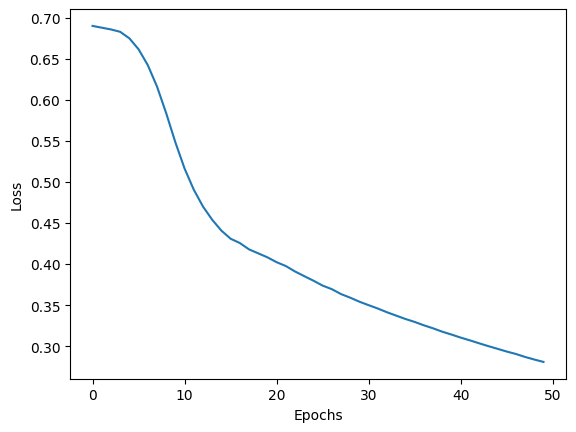

In [ ]:
# Graph
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [ ]:
# Evaluate Model on Test Data Set
model.eval()
with torch.no_grad():
  y_eval = model.forward(X_test)
  loss = criterion(y_eval, y_test)

print(f'Loss: {loss}')

Loss: 0.20996583998203278


In [ ]:
correct = 0
num = []
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)
    num.append(y_val.argmax().item())


    print(f'{i+1}. {str(y_val)} \t {y_test[i]}')
    if y_val.argmax().item() == y_test[i]:
      correct += 1

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test)}% correct')

1. tensor([-9.5391, 14.2051]) 	 1
2. tensor([-0.0561, -3.4977]) 	 0
3. tensor([-1.9906,  2.5453]) 	 1
4. tensor([-0.0922, -4.3572]) 	 0
5. tensor([-2.1627,  3.4218]) 	 1
6. tensor([-0.4587, -2.1416]) 	 0
7. tensor([-0.3298, -1.1201]) 	 1
8. tensor([-3.7975,  5.9335]) 	 1
9. tensor([-0.1348, -2.9440]) 	 0
10. tensor([-1.7389,  1.9105]) 	 1
11. tensor([-5.7771,  8.8117]) 	 1
12. tensor([-0.1645, -3.6173]) 	 0
13. tensor([-0.5168, -1.4486]) 	 0
14. tensor([-8.3679, 12.4475]) 	 1
15. tensor([-0.3598, -3.8412]) 	 0
16. tensor([-0.0655, -4.1075]) 	 0
17. tensor([-3.4178,  5.3198]) 	 1
18. tensor([-0.2480, -2.6805]) 	 1
19. tensor([-0.2638, -3.3642]) 	 1
20. tensor([-0.0860, -3.1209]) 	 0
21. tensor([-4.7548,  7.2511]) 	 1
22. tensor([-0.2941, -2.9297]) 	 0
23. tensor([-6.4139,  9.6846]) 	 1
24. tensor([-0.0287, -3.7708]) 	 1
25. tensor([-0.1488, -3.8469]) 	 0
26. tensor([-0.1342, -3.5561]) 	 0
27. tensor([-11.0624,  16.3829]) 	 1
28. tensor([-0.0490, -2.5125]) 	 0
29. tensor([ 0.0251, -3.942

In [ ]:
num.count(0), num.count(1)

(448, 243)

In [ ]:
confusion_matrix(y_test,num)

array([[408,  15],
       [ 33, 235]])

In [ ]:
print(classification_report(y_test,num))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       423
           1       0.94      0.88      0.91       268

    accuracy                           0.93       691
   macro avg       0.93      0.92      0.93       691
weighted avg       0.93      0.93      0.93       691



In [ ]:
torch.save(model.state_dict(), 'my_pytorch_model.pt')

## Advanced Ensemble Method

In [ ]:
from sklearn.ensemble import StackingClassifier
base_models = [
    ('dt',DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_leaf=8, min_samples_split=8, splitter='best')),
    ('rf', RandomForestClassifier(max_depth = None,max_features = 'sqrt',min_samples_leaf = 1,min_samples_split = 2,n_estimators = 600, random_state=42)),
    ('svm', SVC(probability=True, C = 20, gamma = 0.001, random_state=42)),
    ('gbt', GradientBoostingClassifier(n_estimators=500,min_samples_split=6,min_samples_leaf= 5,learning_rate = 0.1,max_depth = 5,max_features= 'log2',subsample = 1,random_state=42)),
    ('xgb', XGBClassifier(colsample_bytree=1.0,gamma=0.1,learning_rate=0.1,max_depth=9,min_child_weight=1.0,n_estimators=200,subsample=0.6,random_state=42))
]

# Define meta-model
meta_model = LogisticRegression(C=0.001, class_weight=None,max_iter=800, multi_class='auto', penalty=None, solver='saga',random_state=42)

# Create the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Fit the stacking model
stacking_model.fit(X_train, y_train)
train_pred =  stacking_model.predict(X_train)
test_pred = stacking_model.predict(X_test)
model_pred_proba= stacking_model.predict_proba(X_test)[:,1]
print('training accuracy: ',accuracy_score(train_pred,y_train))
print('testing accuracy: ',accuracy_score(test_pred,y_test))
scores = cross_val_score( stacking_model, X_train, y_train, cv=10)  # 10-fold cross-validation
print("Mean cross-validation score:", np.mean(scores))
print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print("Classification report:\n", classification_report(y_test, test_pred))




training accuracy:  0.9543643607388628
testing accuracy:  0.934876989869754
Mean cross-validation score: 0.9224951603620573
roc_auc:  0.9624395751737764
Confusion matrix:
 [[409  14]
 [ 31 237]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       423
           1       0.94      0.88      0.91       268

    accuracy                           0.93       691
   macro avg       0.94      0.93      0.93       691
weighted avg       0.94      0.93      0.93       691



##### Blending Techniques

In [ ]:
# Define the base classifiers
model_1 = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_leaf=8, min_samples_split=8, splitter='best',random_state=42)
model_2 = SVC(probability=True, C = 20, gamma = 0.001, random_state=42)
model_3 = RandomForestClassifier(max_depth = None,max_features = 'sqrt',min_samples_leaf = 1,min_samples_split = 2,n_estimators = 600, random_state=42)
model_4 = GradientBoostingClassifier(n_estimators=500,min_samples_split=6,min_samples_leaf= 5,learning_rate = 0.1,max_depth = 5,max_features= 'log2',subsample = 1,random_state=42)
model_5 = XGBClassifier(colsample_bytree=1.0,gamma=0.1,learning_rate=0.1,max_depth=9,min_child_weight=1.0,n_estimators=200,subsample=0.6,random_state=42)



# Train the classifiers
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
model_4.fit(X_train, y_train)
model_5.fit(X_train, y_train)

# Generate predictions on the holdout set
preds_model_1 = model_1.predict(X_test)
preds_model_2 = model_2.predict(X_test)
preds_model_3 = model_3.predict(X_test)
preds_model_4 = model_4.predict(X_test)
preds_model_5 = model_5.predict(X_test)

# Create a DataFrame to hold the predictions
preds_df = pd.DataFrame({
    'model_1': preds_model_1,
    'model_2': preds_model_2,
    'model_3': preds_model_3,
    'model_4': preds_model_4,
    'model_5': preds_model_5,
})

# Use a logistic regression model to blend the predictions
blender = LogisticRegression(C=0.001, class_weight=None,max_iter=800, multi_class='auto', penalty=None, solver='saga',random_state=42)
blender.fit(preds_df, y_test)

# Final prediction on the holdout set
final_preds = blender.predict(preds_df)

# Evaluate the final model
accuracy = accuracy_score(y_test, final_preds)
print(f"Blended model accuracy: {accuracy:.4f}")
scores = cross_val_score(blender, preds_df, y_test, cv=10)  # 10-fold cross-validation
print("Mean cross-validation score:", np.mean(scores))
print("Confusion matrix:\n", confusion_matrix(y_test, final_preds))
print("Classification report:\n", classification_report(y_test, final_preds))

Blended model accuracy: 0.9349
Mean cross-validation score: 0.9305383022774327
Confusion matrix:
 [[412  11]
 [ 34 234]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       423
           1       0.96      0.87      0.91       268

    accuracy                           0.93       691
   macro avg       0.94      0.92      0.93       691
weighted avg       0.94      0.93      0.93       691



#### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier with the optimized base models
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth = None,max_features = 'sqrt',min_samples_leaf = 1,min_samples_split = 2,n_estimators = 600, random_state=42)),
    ('svc', SVC(probability=True, C = 20, gamma = 0.001, random_state=42)),
    ('logreg', LogisticRegression(C=0.001, class_weight=None,max_iter=800, multi_class='auto', penalty=None, solver='saga',random_state=42)),
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_leaf=8, min_samples_split=8, splitter='best',random_state=42)),
    ('xgb', XGBClassifier(colsample_bytree=1.0,gamma=0.1,learning_rate=0.1,max_depth=9,min_child_weight=1.0,n_estimators=200,subsample=0.6,random_state=42)),
    ('gbt', GradientBoostingClassifier(n_estimators=500,min_samples_split=6,min_samples_leaf= 5,learning_rate = 0.1,max_depth = 5,max_features= 'log2',subsample = 1,random_state=42))
], voting='soft')  # Use soft voting for probability-based predictions

# Train the voting classifier
voting_clf.fit(X_train, y_train)

train_pred =  voting_clf.predict(X_train)
test_pred = voting_clf.predict(X_test)
model_pred_proba= voting_clf.predict_proba(X_test)[:,1]
print('training accuracy: ',accuracy_score(train_pred,y_train))
print('testing accuracy: ',accuracy_score(test_pred,y_test))
scores = cross_val_score(voting_clf, X_train, y_train, cv=10)  # 10-fold cross-validation
print("Mean cross-validation score:", np.mean(scores))
print('roc_auc: ', roc_auc_score(y_test,model_pred_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print("Classification report:\n", classification_report(y_test, test_pred))

training accuracy:  0.9764578051430641
testing accuracy:  0.934876989869754
Mean cross-validation score: 0.9210445769894837
roc_auc:  0.9598990861296355
Confusion matrix:
 [[412  11]
 [ 34 234]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95       423
           1       0.96      0.87      0.91       268

    accuracy                           0.93       691
   macro avg       0.94      0.92      0.93       691
weighted avg       0.94      0.93      0.93       691



In [ ]:
# Save the stacking model

with open('votingclassifier_model.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)

with open('blender_model.pkl', 'wb') as f:
    pickle.dump(blender, f)

with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

# Save the best models
with open('best_logreg_model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

with open('best_dt_model.pkl', 'wb') as f:
    pickle.dump(dt, f)

with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('best_gbt_model.pkl', 'wb') as f:
    pickle.dump(gbt, f)

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)

print("Models saved successfully.")

#  Feature Importance and Model Interpretability

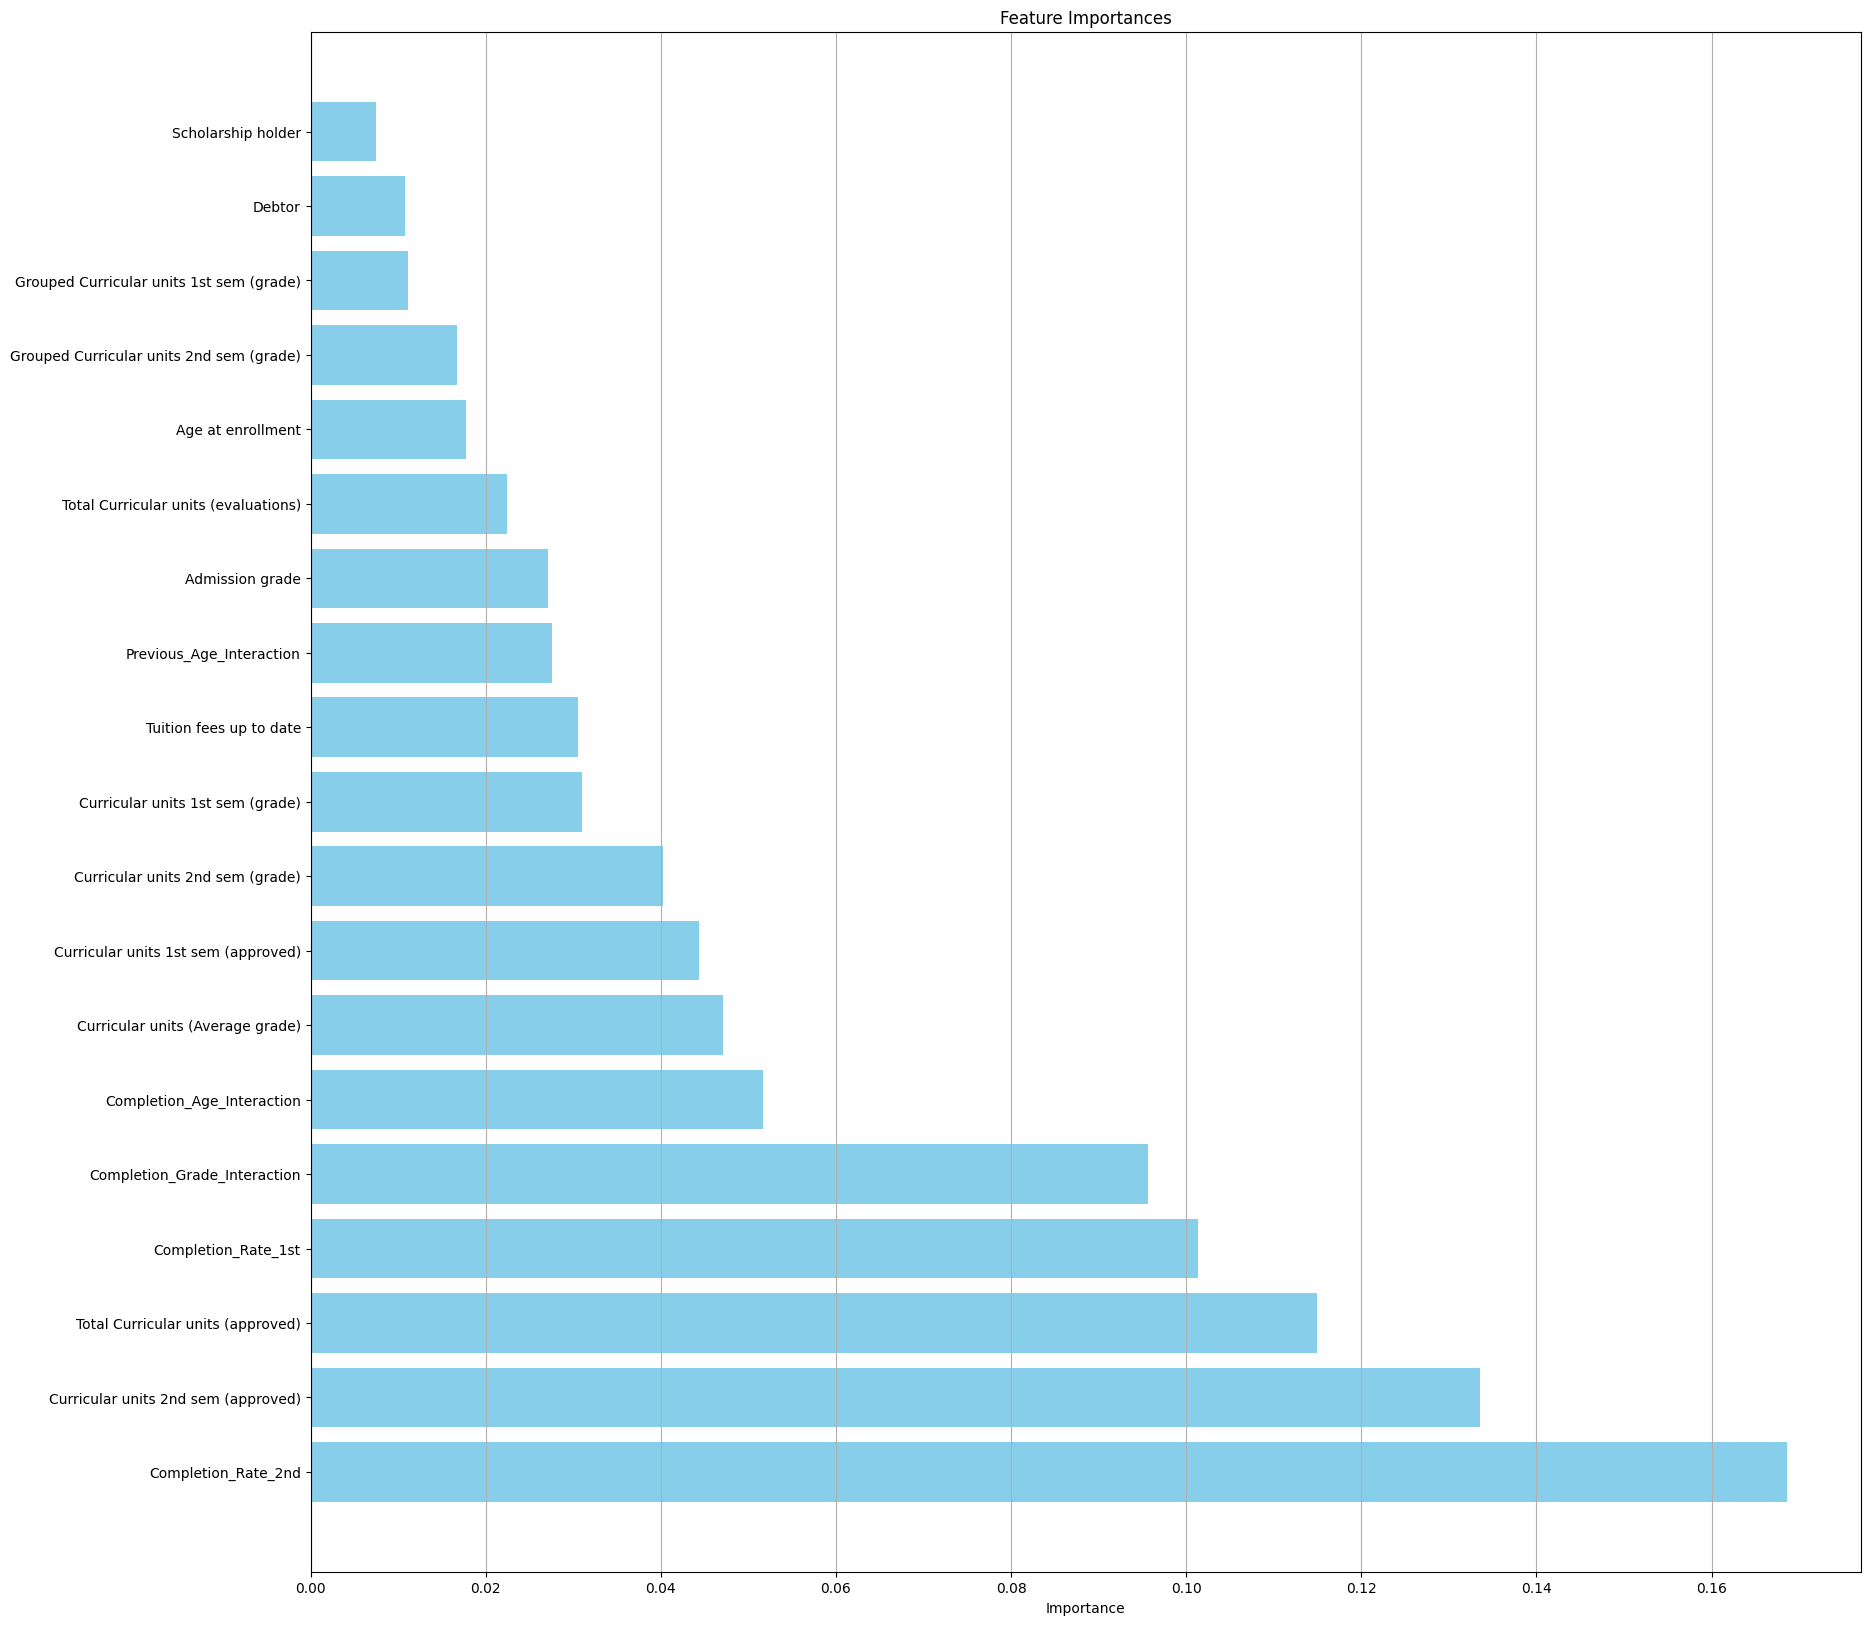

In [ ]:
# Train a Random Forest model
model = RandomForestClassifier(max_depth = None,max_features = 'sqrt',min_samples_leaf = 1,min_samples_split = 2,n_estimators = 600, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
rf_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
rf_importances = rf_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20, 20))
plt.barh(rf_importances['Feature'], rf_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.grid(axis='x')
plt.show()

In [ ]:
rf_col= rf_importances[rf_importances['Importance'] >= 0.01]['Feature'].to_list()
rf_col

['Completion_Rate_2nd',
 'Completion_Rate_1st',
 'Curricular units 2nd sem (approved)',
 'Total Curricular units (approved)',
 'Completion_Grade_Interaction',
 'Completion_Age_Interaction',
 'Curricular units 1st sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units (Average grade)',
 'Grouped Curricular units 2nd sem (grade)',
 'Curricular units 1st sem (grade)',
 'Tuition fees up to date',
 'Grouped Curricular units 1st sem (grade)',
 'Total Curricular units (evaluations)',
 'Previous_Age_Interaction',
 'Curricular units 2nd sem (evaluations)',
 'Admission grade',
 'Grade_Interaction',
 'Age at enrollment',
 'Previous qualification (grade)',
 'Curricular units 1st sem (evaluations).1',
 'Curricular units 1st sem (evaluations)']

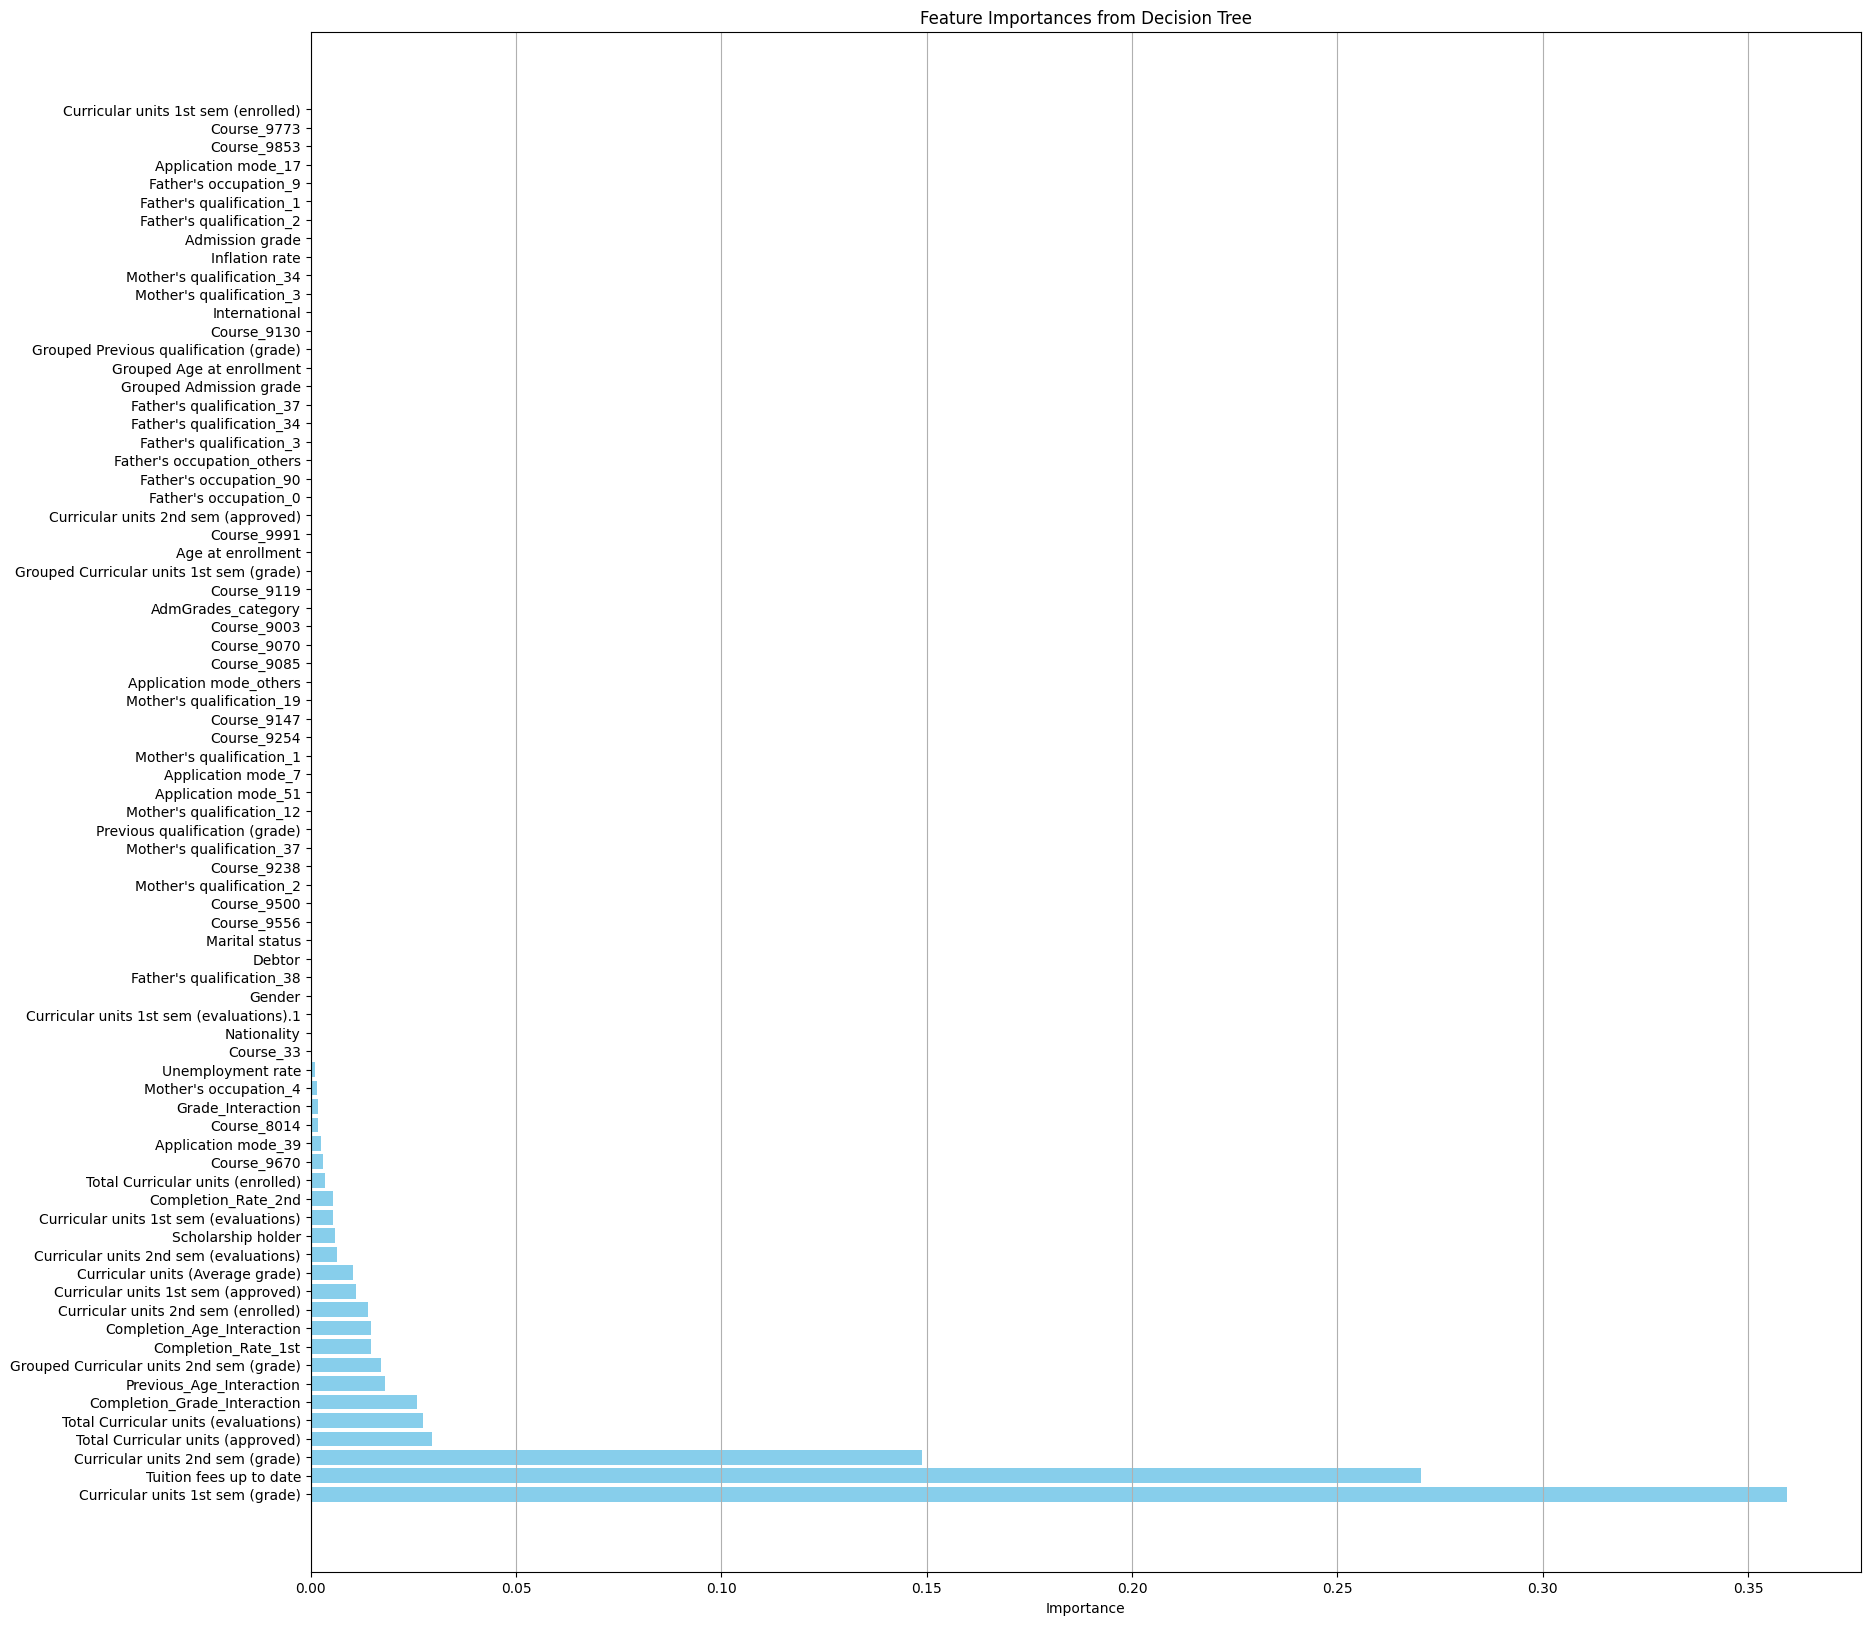

In [ ]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt', min_samples_leaf=8, min_samples_split=8, splitter='best',random_state=42)
dt_model.fit(X_train, y_train)

# Get feature importances
importances = dt_model.feature_importances_
dt_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
dt_importances = dt_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20,20))
plt.barh(dt_importances['Feature'], dt_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.grid(axis='x')
plt.show()

In [ ]:
dt_col= dt_importances[dt_importances['Importance'] >= 0.01]['Feature'].to_list()
dt_col

['Curricular units 1st sem (grade)',
 'Tuition fees up to date',
 'Curricular units 2nd sem (grade)',
 'Total Curricular units (approved)',
 'Total Curricular units (evaluations)',
 'Completion_Grade_Interaction',
 'Previous_Age_Interaction',
 'Grouped Curricular units 2nd sem (grade)',
 'Completion_Rate_1st',
 'Completion_Age_Interaction',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 1st sem (approved)',
 'Curricular units (Average grade)']

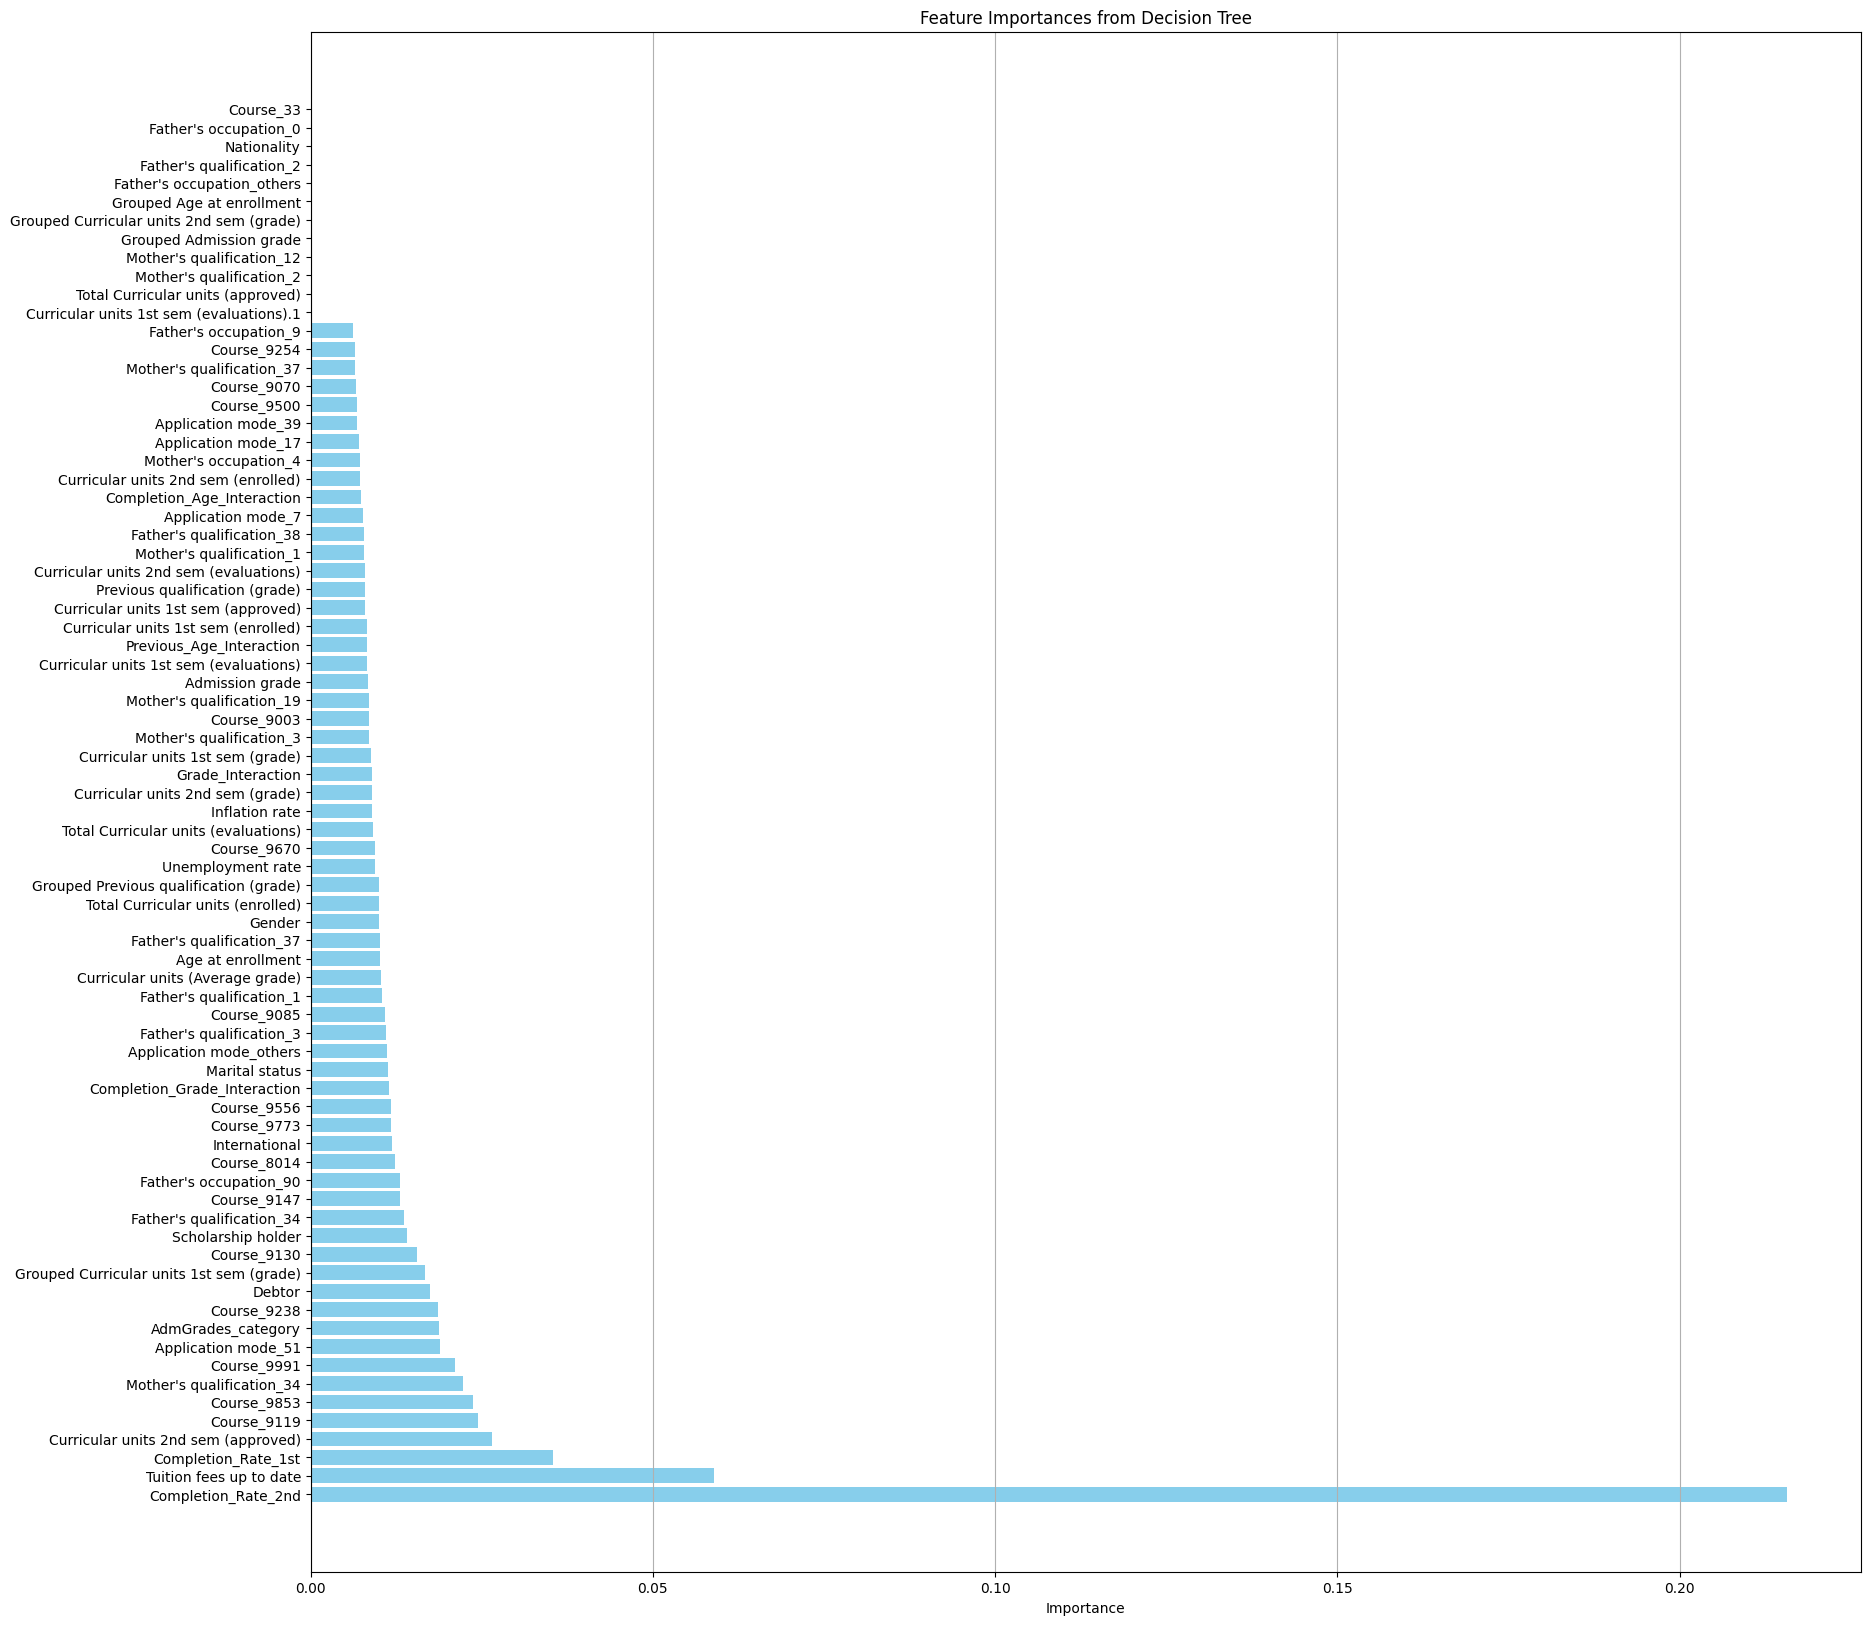

In [ ]:
xgb = XGBClassifier(colsample_bytree=1.0,gamma=0.1,learning_rate=0.1,max_depth=9,min_child_weight=1.0,n_estimators=200,subsample=0.6,random_state=42)
xgb.fit(X_train, y_train)

# Get feature importances
importances = xgb.feature_importances_
xgb_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20,20))
plt.barh(xgb_importances['Feature'], xgb_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.grid(axis='x')
plt.show()

In [ ]:
xgb_col= xgb_importances[xgb_importances['Importance'] >= 0.01]['Feature'].to_list()
xgb_col

['Completion_Rate_2nd',
 'Tuition fees up to date',
 'Completion_Rate_1st',
 'Curricular units 2nd sem (approved)',
 'Course_9119',
 'Course_9853',
 "Mother's qualification_34",
 'Course_9991',
 'Application mode_51',
 'AdmGrades_category',
 'Course_9238',
 'Debtor',
 'Grouped Curricular units 1st sem (grade)',
 'Course_9130',
 'Scholarship holder',
 "Father's qualification_34",
 'Course_9147',
 "Father's occupation_90",
 'Course_8014',
 'International',
 'Course_9773',
 'Course_9556',
 'Completion_Grade_Interaction',
 'Marital status',
 'Application mode_others',
 "Father's qualification_3",
 'Course_9085',
 "Father's qualification_1",
 'Curricular units (Average grade)',
 'Age at enrollment',
 "Father's qualification_37",
 'Gender']

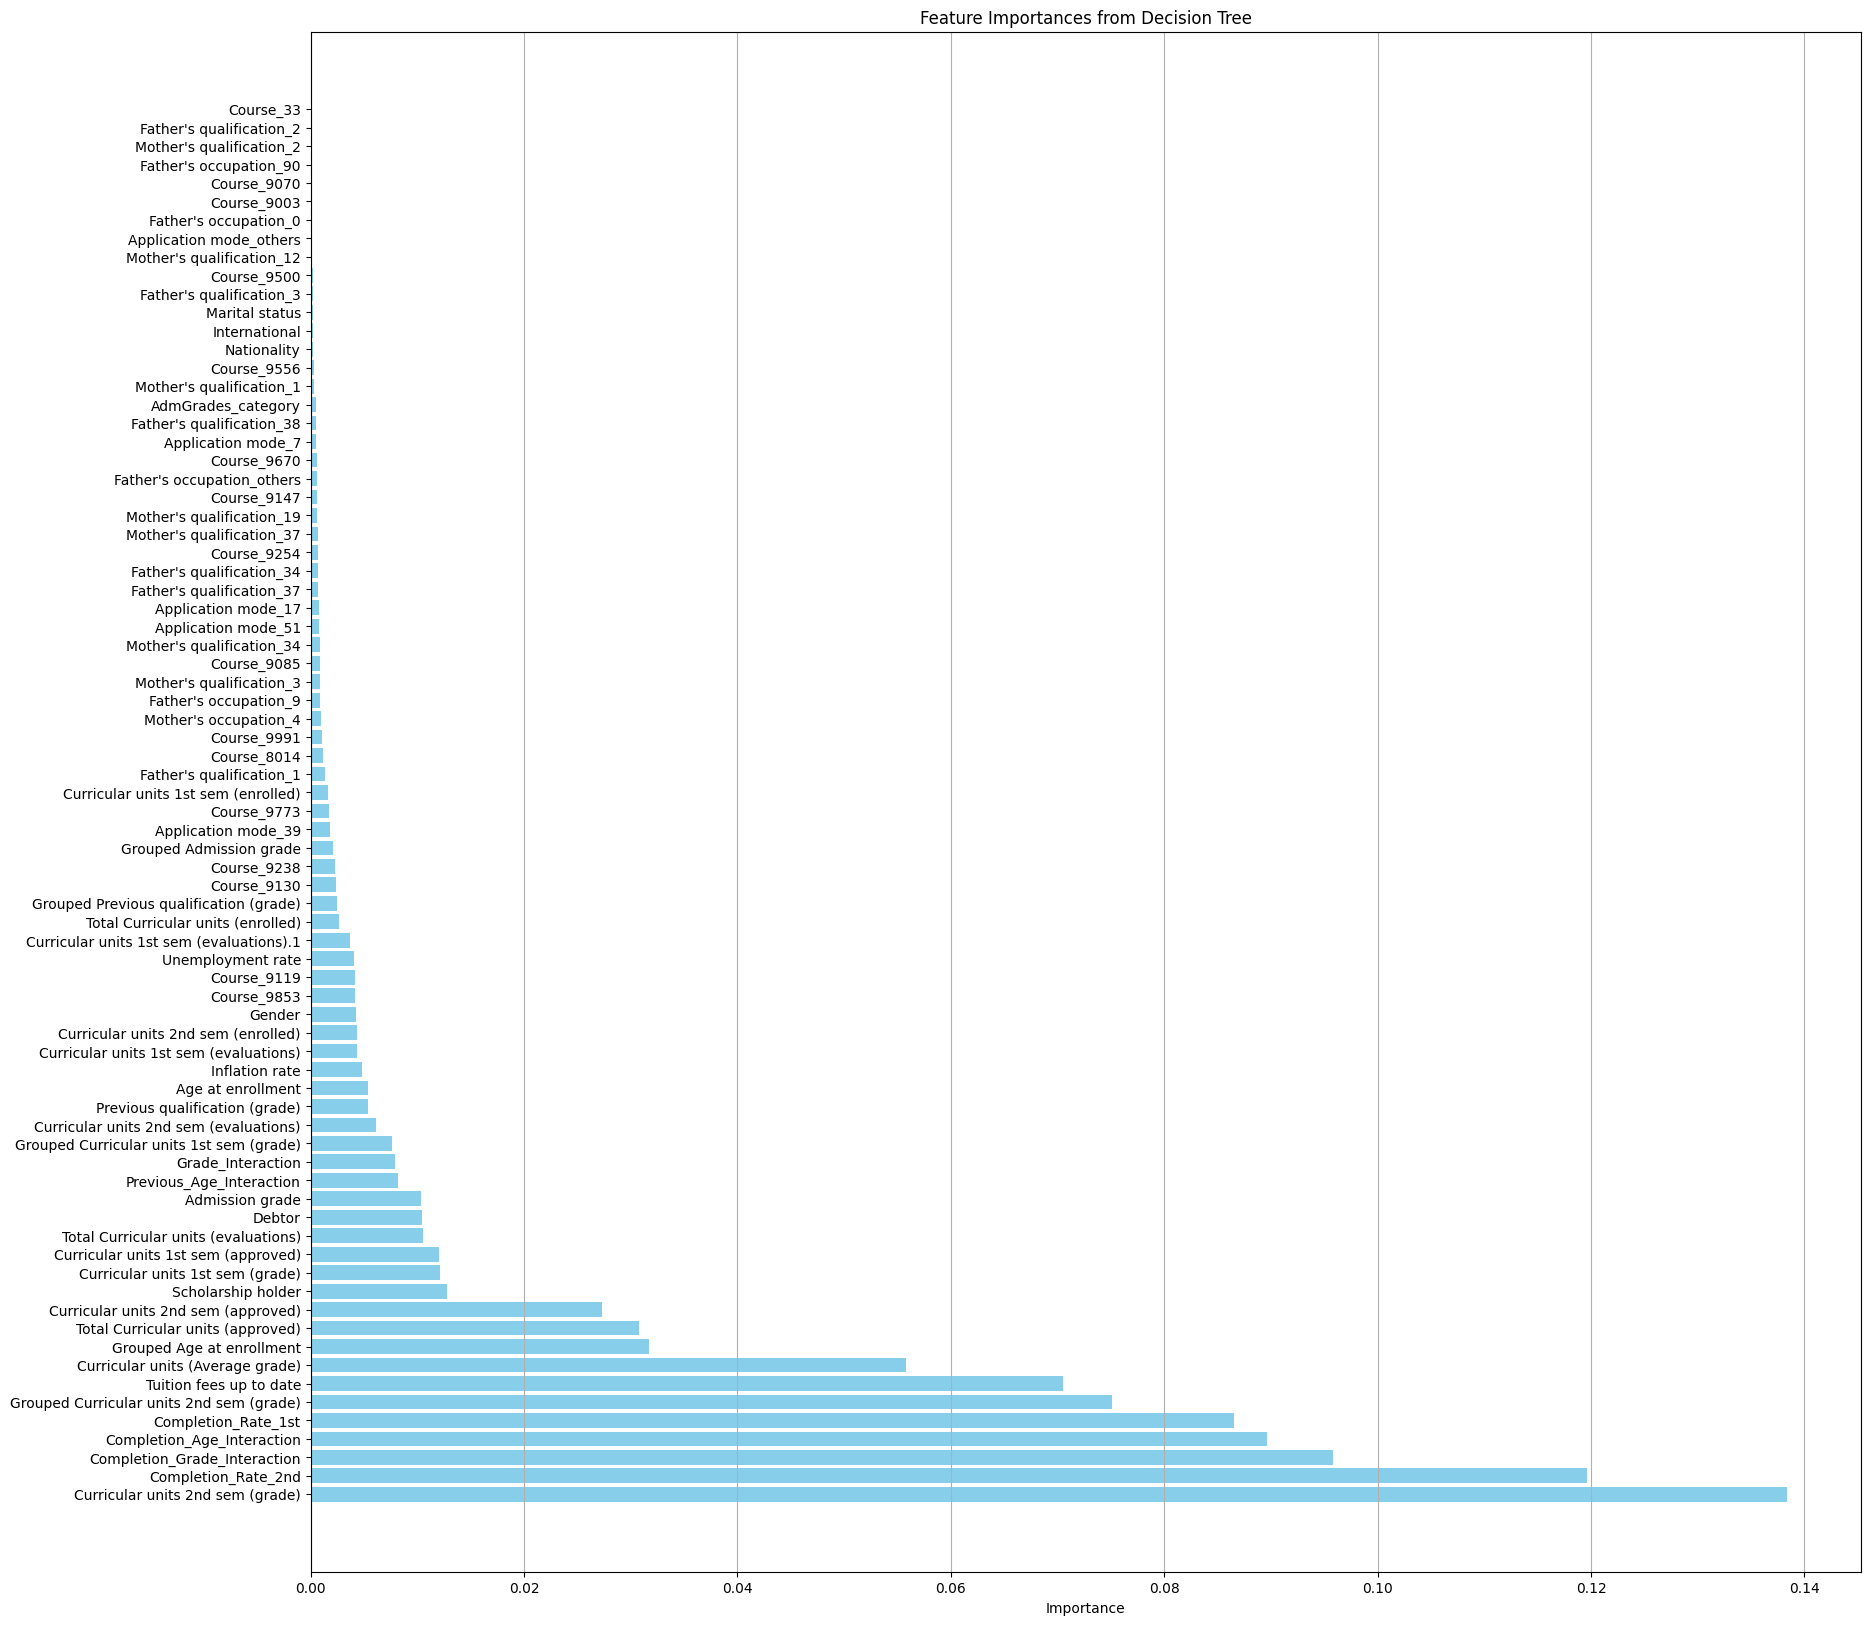

In [ ]:
gbt =  GradientBoostingClassifier(n_estimators=500,min_samples_split=6,min_samples_leaf= 5,learning_rate = 0.1,max_depth = 5,max_features= 'log2',subsample = 1,random_state=42)
gbt.fit(X_train, y_train)

# Get feature importances
importances = gbt.feature_importances_
gbt_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
gbt_importances = gbt_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(20,20))
plt.barh(gbt_importances['Feature'], gbt_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.grid(axis='x')
plt.show()